In [1]:
%matplotlib inline
#%matplotlib widget

In [2]:
from importlib import reload
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from opticalglass.spectral_lines import get_wavelength
import opticalglass.glassfactory as gfact
import opticalglass.glassmap as gmap
import opticalglass.buchdahl as buchdahl
from opticalglass.buchdahl import get_wv, omega, omega2wvl
import opticalglass.schott as schott
import opticalglass.glass as glass
import opticalglass.modelglass as mg
import opticalglass.util as util

In [3]:
def rindex(data, wvl):
    base, coefs = data
    wl0, rind0 = base
    om = omega(get_wv(wvl) - get_wv(wl0))
    return rind0 + coefs[0]*om + coefs[1]*om**2

In [4]:
omC=omega(get_wv('C')-get_wv('d')); omC

0.05863804688051722

In [5]:
omF=omega(get_wv('F')-get_wv('d')); omF

-0.13588611616202362

In [6]:
wlC = omega2wvl(omC) + get_wv('d'); wlC

0.6562725

In [7]:
wlF = omega2wvl(omF) + get_wv('d'); wlF

0.48613270000000003

In [8]:
bk7 = gfact.create_glass('N-BK7', 'Schott')

In [9]:
rind_bk7 = [bk7.rindex('F'), bk7.rindex('d'), bk7.rindex('C')]

In [10]:
rind_bk7

[1.5223762897312285, 1.5168000345005885, 1.5143223472613747]

In [11]:
a = np.array([[omF, omF**2], [omC, omC**2]])

In [12]:
b = np.array([rind_bk7[0]-rind_bk7[1], rind_bk7[2]-rind_bk7[1]])

In [13]:
a, b

(array([[-0.13588612,  0.01846504],
        [ 0.05863805,  0.00343842]]),
 array([ 0.00557626, -0.00247769]))

In [14]:
coefs = np.linalg.solve(a, b)

In [15]:
data = ((get_wavelength('d'), rind_bk7[1]), coefs)

In [16]:
bcc_index = np.array([rindex(data, wvl) for wvl in range(450, 700, 5)])

In [17]:
cat_index = np.array([bk7.rindex(wvl) for wvl in range(450, 700, 5)])

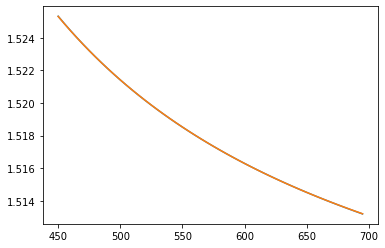

In [18]:
wl = np.arange(450, 700, 5)
plt.plot(wl, cat_index, wl, bcc_index)
plt.show()

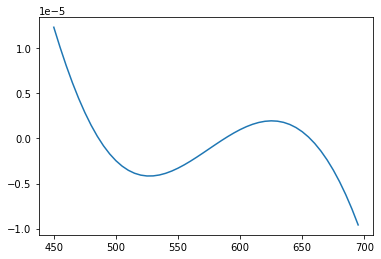

In [19]:
plt.plot(wl, cat_index-bcc_index)
plt.show()

# Calculate a model from glass catalog data

In [20]:
def calc_glass_constants(g):
    nd = g.rindex('d')
    nF = g.rindex('F')
    nC = g.rindex('C')
    dFC = nF-nC
    vd = (nd - 1.0)/dFC
    PCd = (nd-nC)/dFC
    return vd, PCd

In [21]:
glasses = gmap.GlassMapDB()

In [22]:
v1 = None
v2 = None
for i, display in enumerate(glasses.catalogs):
    n, v, p, c0, c1, lbl = glasses.get_data_at(i)
    dsLabel = glasses.get_data_set_label_at(i)
    if v1 is None:
        v1 = np.array(c0)
    else:
        np.append(c0, v1)
    if v2 is None:
        v2 = np.array(c1)
    else:
        np.append(c1, v2)

In [23]:
slope, intercept, r_value, p_value, std_err = stats.linregress(v2, v1)

In [24]:
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: -1.657933    intercept: -0.063092
R-squared: 0.927044


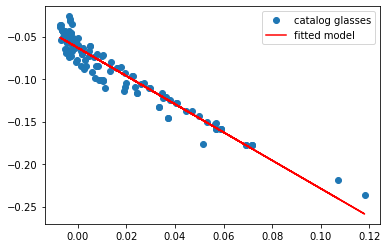

In [25]:
plt.plot(v2, v1, 'o', label='catalog glasses')
plt.plot(v2, intercept + slope*v2, 'r', label='fitted model')
plt.legend()
plt.show()

In [26]:
schott_cat = schott.SchottCatalog()

In [27]:
schott_data = schott_cat.glass_map_data()

In [28]:
m, b, r_value, p_value, std_err = stats.linregress(schott_data[4], schott_data[3])

In [29]:
print("slope: %f    intercept: %f" % (m, b))
print("R-squared: %f" % r_value**2)

slope: -1.657933    intercept: -0.063092
R-squared: 0.927044


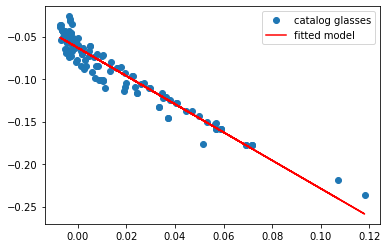

In [30]:
plt.plot(schott_data[4], schott_data[3], 'o', label='catalog glasses')
plt.plot(schott_data[4], b + m*schott_data[4], 'r', label='fitted model')
plt.legend()
plt.show()

In [31]:
bk7 = gfact.create_glass('N-BK7', 'Schott')
bk7_mod1 = buchdahl.Buchdahl1(bk7)
bk7_mod2a = buchdahl.Buchdahl2(1.5168, 64.7)
bk7_mod2b = buchdahl.Buchdahl2(1.5168, 64.7, model=(b, m))

In [32]:
bk7.rindex('F'), bk7_mod2a.rindex('F'), bk7_mod2b.rindex('F')

(1.5223762897312285, 1.521932057689993, 1.5219761743516536)

In [33]:
bk7_mod1.rindex('F')-bk7.rindex('F'), bk7_mod1.rindex('F')-bk7.rindex('F')

(0.0, 0.0)

In [34]:
bk7_mod2a.rindex('F')-bk7.rindex('F'), bk7_mod2b.rindex('F')-bk7.rindex('F')

(-0.00044423204123544835, -0.00040011537957496124)

In [35]:
calc_glass_constants(bk7_mod2a)

(68.69593018428556, 0.31781834989648855)

In [36]:
calc_glass_constants(bk7_mod2b)

(68.28043080164775, 0.31611568375512855)

In [37]:
calc_glass_constants(bk7_mod1)

(64.1673362374998, 0.30763657034898056)

In [38]:
r_value, p_value, std_err

(-0.9628312984980117, 1.2330322894690326e-70, 0.042281888437910295)

In [39]:
r, p = stats.pearsonr(schott_data[4], schott_data[3])

In [40]:
r,p

(-0.962831298498012, 1.2330322894685598e-70)

In [41]:
r_value, p_value

(-0.9628312984980117, 1.2330322894690326e-70)

In [42]:
sf6 = gfact.create_glass('N-SF6', 'Schott')

In [43]:
sf6_mod1 = buchdahl.Buchdahl1(sf6)
sf6_mod2a = buchdahl.Buchdahl2(1.8052, 25.36)
sf6_mod2b = buchdahl.Buchdahl2(1.8052, 25.36, model=(b, m))

In [44]:
model_bk7_sf6 = mg.model_from_glasses(bk7, sf6)

In [45]:
model_bk7_sf6

(-0.053099551406849715, -1.7912280320568652)

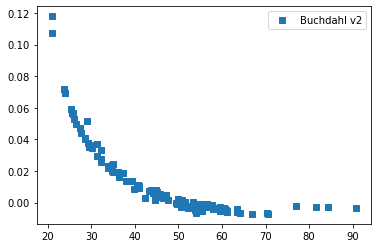

In [46]:
#plt.plot(schott_data[1], schott_data[3], 'o', label='Buchdahl v1')
plt.plot(schott_data[1], schott_data[4], 's', label='Buchdahl v2')
#plt.plot(schott_data[1], model_bk7_sf6[0] + model_bk7_sf6[1]*schott_data[4], 'r', label='fitted model')
#plt.axes.invert_xaxis()
plt.legend()
plt.show()

In [47]:
schott_data[4][0]

0.01626635430120273

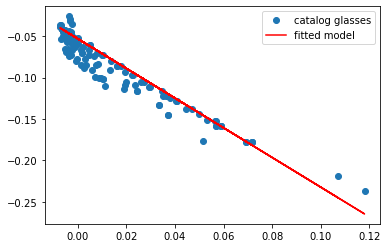

In [48]:
plt.plot(v2, v1, 'o', label='catalog glasses')
plt.plot(v2, model_bk7_sf6[0] + model_bk7_sf6[1]*v2, 'r', label='fitted model')
#plt.plot(schott_data[4], schott_data[3], 'o', label='catalog glasses')
#plt.plot(schott_data[4], model_bk7_sf6[0] + model_bk7_sf6[1]*schott_data[4], 'r', label='fitted model')
plt.legend()
plt.show()

In [49]:
bk7_mod2c = buchdahl.Buchdahl2(1.5168, 64.7, model=(model_bk7_sf6))

In [50]:
bk7_mod2a.rindex('F')-bk7.rindex('F'), bk7_mod2b.rindex('F')-bk7.rindex('F'), bk7_mod2c.rindex('F')-bk7.rindex('F')

(-0.00044423204123544835, -0.00040011537957496124, -0.00019987253609055067)

In [51]:
sf6_mod2c = buchdahl.Buchdahl2(1.8052, 25.36, model=(model_bk7_sf6))

In [52]:
sf6_mod1.rindex('F')-sf6.rindex('F'), sf6_mod1.rindex('F')-sf6.rindex('F')

(0.0, 0.0)

In [53]:
sf6_mod2a.rindex('F')-sf6.rindex('F'), sf6_mod2b.rindex('F')-sf6.rindex('F'), sf6_mod2c.rindex('F')-sf6.rindex('F')

(0.0014200274898692467, 0.0013851486773386323, 0.0014113229992955834)

In [54]:
vars(sf6_mod2b)

{'b': -0.06309227969936954,
 'm': -1.6579333920474613,
 'om': (-0.13588611616202362,
  0.05863804688051722,
  -0.19452416304254083,
  0.015026616023637243),
 'wv0': 0.5875617999999999,
 'rind0': 1.8052,
 'coefs': array([-0.16811623,  0.0633463 ]),
 'label': '',
 '_catalog_name': ''}

In [55]:
vars(sf6_mod1)

{'om': (-0.13588611616202362, 0.05863804688051722),
 'wv0': 0.5875617999999999,
 'rind0': 1.8051801846158335,
 'coefs': array([-0.15866786,  0.05893628]),
 'label': '',
 '_catalog_name': ''}

In [56]:
vars(bk7_mod1)

{'om': (-0.13588611616202362, 0.05863804688051722),
 'wv0': 0.5875617999999999,
 'rind0': 1.5168000345005885,
 'coefs': array([-0.04188686, -0.00625978]),
 'label': '',
 '_catalog_name': ''}

In [57]:
m_sf6_bk7 = (bk7_mod1.coefs[0] - sf6_mod1.coefs[0])/(bk7_mod1.coefs[1] - sf6_mod1.coefs[1])

In [58]:
b_sf6_bk7 = bk7_mod1.coefs[1] - m_sf6_bk7*bk7_mod1.coefs[0]

In [59]:
b_sf6_bk7, m_sf6_bk7

(-0.081288692918037, -1.7912280320568652)

In [60]:
vars(sf6_mod2c)

{'b': -0.053099551406849715,
 'm': -1.7912280320568652,
 'om': (-0.13588611616202362,
  0.05863804688051722,
  -0.19452416304254083,
  0.015026616023637243),
 'wv0': 0.5875617999999999,
 'rind0': 1.8052,
 'coefs': array([-0.16818604,  0.06425005]),
 'label': '',
 '_catalog_name': ''}

In [61]:
model_bk7_sf6

(-0.053099551406849715, -1.7912280320568652)

In [62]:
mg.model_from_glasses(bk7, sf6)

(-0.053099551406849715, -1.7912280320568652)

In [63]:
sf6_mod2d = buchdahl.Buchdahl2(1.8052, 25.36, model=(b_sf6_bk7, m_sf6_bk7))

In [64]:
sf6_mod2b.rindex('F')-sf6.rindex('F')

0.0013851486773386323

In [65]:
sf6_mod2d.rindex('F')-sf6.rindex('F')

0.000934996976329705

In [66]:
util.calc_glass_constants(sf6_mod2d.rindex('d'), sf6_mod2d.rindex('F'), sf6_mod2d.rindex('C'))

(24.262193037508457, 0.7100337984367162)

In [67]:
sf6_mod2d.rindex('d')

1.8052